In [1]:
import os
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

import torchvision
from torchvision.io import read_image
from torchvision.transforms import ToPILImage, ToTensor, Normalize

import librosa
import librosa.display

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Audio, display

import numpy as np
import pandas as pd

import glob

In [2]:
TRAIN_DATASET_PATH = '../VC-PRG-1_5/'
train_audio_files = glob.glob(TRAIN_DATASET_PATH + '*.wav')
train_vc_files = glob.glob(TRAIN_DATASET_PATH + '*.txt')

train_audio_files = sorted(train_audio_files)
train_vc_files = sorted(train_vc_files)

TEST_DATASET_PATH = '../VC-PRG-6/'
test_audio_files = glob.glob(TEST_DATASET_PATH + '*.wav')
test_vc_files = glob.glob(TEST_DATASET_PATH + '*.txt')

test_audio_files = sorted(test_audio_files)
test_vc_files = sorted(test_vc_files)

In [3]:
def get_vc(filename):
    with open(filename) as f:
        minima = f.readlines()
    minima_positions = np.array([float(x.strip()) for x in minima])
    vehicle_count = 0
    if minima_positions[0] >= 0:
        vehicle_count = minima_positions.size
    return vehicle_count

In [4]:
train_vehicle_counts = list()
for i in range(len(train_vc_files)):
    vc = get_vc(train_vc_files[i])
    train_vehicle_counts.append(vc)
d = {x:train_vehicle_counts.count(x) for x in train_vehicle_counts}

print("\nIn Training Dataset\n--------------------------------")
for k, v in d.items():
    print(f"# of Cars {k}:\t\tCount: {v}")

test_vehicle_counts = list()
for i in range(len(test_vc_files)):
    vc = get_vc(test_vc_files[i])
    test_vehicle_counts.append(vc)
d = {x:test_vehicle_counts.count(x) for x in test_vehicle_counts}

print("\nIn Testing Dataset\n--------------------------------")
for k, v in d.items():
    print(f"# of Cars {k}:\t\tCount: {v}")


In Training Dataset
--------------------------------
# of Cars 3:		Count: 56
# of Cars 2:		Count: 50
# of Cars 5:		Count: 30
# of Cars 6:		Count: 19
# of Cars 4:		Count: 56
# of Cars 7:		Count: 5
# of Cars 0:		Count: 20
# of Cars 8:		Count: 4
# of Cars 9:		Count: 1
# of Cars 1:		Count: 9

In Testing Dataset
--------------------------------
# of Cars 4:		Count: 27
# of Cars 2:		Count: 25
# of Cars 3:		Count: 33
# of Cars 6:		Count: 13
# of Cars 1:		Count: 23
# of Cars 5:		Count: 16
# of Cars 7:		Count: 10
# of Cars 9:		Count: 2
# of Cars 8:		Count: 4
# of Cars 10:		Count: 1
# of Cars 12:		Count: 1
# of Cars 0:		Count: 17


In [22]:
n_mels = 128
mel_transformer = T.MelSpectrogram(
    sample_rate=22050,
    n_fft=2048,
    win_length=1024,
    hop_length=512,
    n_mels=n_mels,
)

In [6]:
def save_audio_spectrogram_img(target_sample_rate, duration, audio_files, vc_files, index, output_dir=""):
    filename = audio_files[index]
    signal, sample_rate = torchaudio.load(filename)

    # Mix if channels > 1
    if signal.shape[0] > 1:
        signal = signal.mean(axis=0)

    # Resample if sample rate != 22050
    if sample_rate != target_sample_rate:
        signal = T.Resample(sample_rate, target_sample_rate)(signal)

    # Cut if signal > 20 seconds
    if signal.size(0) > duration * target_sample_rate:
        signal = signal[:duration * target_sample_rate]

    # Pad if signal < 20 seconds
    if signal.size(0) < duration * target_sample_rate:
        num_missing_samples = duration * target_sample_rate - signal.size(0)
        last_dim_padding = (0, num_missing_samples)
        signal = torch.nn.functional.pad(signal, last_dim_padding)

    # Convert to Mel Spectrogram
    mel_spec = mel_transformer(signal)

    # Convert to dB scale
    log_mel_spec = F.amplitude_to_DB(mel_spec, 10, 1e-2, np.log10(max(mel_spec.max(), 1e-2)))

    title = os.path.basename(audio_files[index]).replace("wav", "") + f"-{get_vc(filename.replace('wav', 'txt'))}"

    # px = 1/plt.rcParams['figure.dpi']
    # fig = plt.Figure(figsize=(224 * px, 224 * px))
    fig = plt.Figure(figsize=(4, 4))
    plt.imshow(log_mel_spec, aspect='auto', origin='lower')
    plt.tight_layout()
    plt.axis('off')
    plt.savefig(output_dir + title + ".png", transparent=True, bbox_inches='tight', pad_inches=0)

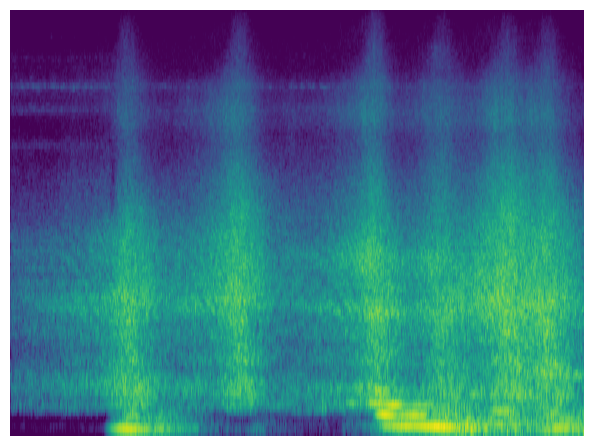

In [31]:
n_mels = 128
mel_transformer = T.MelSpectrogram(
    sample_rate=22050,
    n_fft=2048,
    win_length=1024,
    hop_length=512,
    n_mels=n_mels,
)

index = 50
output_dir = "../dataset/VC-PRG-6-IMG/"
save_audio_spectrogram_img(22050, 20, train_audio_files, train_vc_files,index, output_dir)

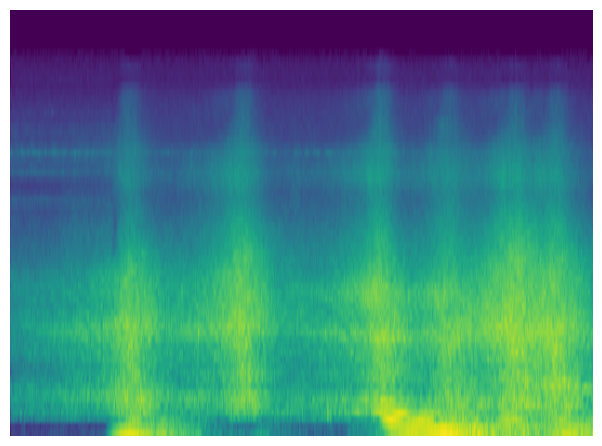

In [32]:
n_mels = 64
mel_transformer = T.MelSpectrogram(
    sample_rate=44100,
    n_fft=8192,
    win_length=4096,
    hop_length=1638,
    n_mels=n_mels,
)

index = 50
output_dir = "../dataset/VC-PRG-6-IMG/"
save_audio_spectrogram_img(44100, 20, train_audio_files, train_vc_files,index, output_dir)

In [ ]:
for index in range(len(train_audio_files)):
    output_dir = "../dataset/VC-PRG-1_5-IMG/"
    save_audio_spectrogram_img(22050, 20, train_audio_files, train_vc_files,index, output_dir)

In [ ]:
for index in range(len(test_audio_files)):
    output_dir = "../dataset/VC-PRG-6-IMG/"
    save_audio_spectrogram_img(22050, 20, test_audio_files, test_vc_files,index, output_dir)

In [ ]:
index = 0
output_dir = "../dataset/VC-PRG-1_5-IMG/"
filename = os.path.basename(train_audio_files[index]).replace("wav", "") + "-" + str(get_vc(train_vc_files[index])) + ".png"
img = read_image(output_dir + filename)
print(img.size())

# Resize to 224x224
img = torchvision.transforms.Resize((224, 224), interpolation=torchvision.transforms.InterpolationMode.BILINEAR)(img)

# Show
img = torchvision.transforms.ToPILImage()(img)
img.show()